# Tuning a Neural Network's arhcitecture and hyperparameters with a genetic algorithm

This notebook will show how a neural network's architecture and hyperparameters can be tuned using a **genetic algorithm**. The NN will be evaluated on the sonar dataset. 

The datasety can be found in the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Connectionist+Bench+(Sonar,+Mines+vs.+Rocks))

The NN evaluation function was informed by this [web page](https://machinelearningmastery.com/binary-classification-tutorial-with-the-keras-deep-learning-library/)

## Importing the main packages

In [1]:
import pandas as pd
from evolution_opt.genetic import *

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


Using TensorFlow backend.


## Reading and preparing sonar dataset

In [2]:
# load dataset
dataframe = pd.read_csv('sonar_dataset.txt', header=None)
dataset = dataframe.values
# split into input (X) and output (Y) variables
X = dataset[:,0:60].astype(float)
Y = dataset[:,60]
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)

## Coding the evaluation function

In [3]:
def evaluate_nn(param_dict):
    '''
    This function will create and evaluate a NN based on the parameters of a given individual
    '''
    def model_build():
        model = Sequential()
        model.add(Dense(param_dict['n_neurons_layer1'], input_dim=60, activation=param_dict['activation_fn']))
        #The NN architecture will not set a dropout superior to 0.5
        #If a dropout parameter has a value superior to 0.5, no dropout is applied
        if param_dict['dropout_1'] < 0.5:
        model.add(Dropout(param_dict['dropout_1']))
        if param_dict['n_hidden_layers'] >= 2:
            model.add(Dense(param_dict['n_neurons_layer2'], activation=param_dict['activation_fn']))
            if param_dict['dropout_2'] < 0.5:
            model.add(Dropout(param_dict['dropout_2']))
        if param_dict['n_hidden_layers'] >= 3:
            model.add(Dense(param_dict['n_neurons_layer3'], activation=param_dict['activation_fn']))
            if param_dict['dropout_3'] < 0.5:
            model.add(Dropout(param_dict['dropout_3']))
        model.add(Dense(1, activation='sigmoid'))
        # Compile model
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        return model
    # evaluate baseline model with standardized dataset
    estimators = []
    estimators.append(('standardize', StandardScaler()))
    estimators.append(('mlp', KerasClassifier(build_fn=model_build, epochs=param_dict['n_epochs'], batch_size=param_dict['batch_size'], verbose=0)))
    pipeline = Pipeline(estimators)
    kfold = StratifiedKFold(n_splits=3, shuffle=True)
    results = cross_val_score(pipeline, X, encoded_Y, cv=kfold)
    #Returns the average accuracy across the cross validation splits
    return np.mean(results)

## Defining the search space

In [7]:
search_space = [
    Real(0.001, 0.8, 'learning_rate', precision = 2, prior = 'lognormal', mean = 0.1, stdev = 1),
    Integer(1,3, 'n_hidden_layers'),
    Integer(20, 140, 'n_epochs', step = 20),
    Integer(2, 32, 'batch_size', step = 2),
    Categorical(['relu', 'sigmoid', 'tanh'], 'activation_fn'),
    Integer(20, 150, 'n_neurons_layer1', step = 10),
    Integer(20, 150, 'n_neurons_layer2', step = 10),
    Integer(20, 150, 'n_neurons_layer3', step = 10),
    Real(0, 1, 'dropout_1', precision = 2),
    Real(0, 1, 'dropout_2', precision = 2),
    Real(0, 1, 'dropout_3', precision = 2),
]

**Note**: A dropout percentage inferior to 0.5 means no dropout

## Sense-checking prior distributions

**Note**: defining a prior distribution is not compulsory. The default prior distribution is uniform.

Parameter Name: learning_rate 
Prior Distribution: lognormal
Mean: 0.1 
Standard Deviation: 1



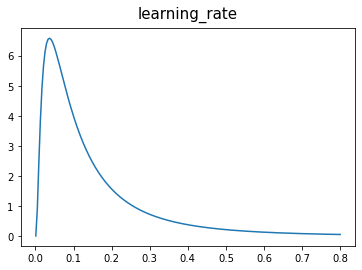

Parameter Name: dropout_1 
Prior Distribution: uniform


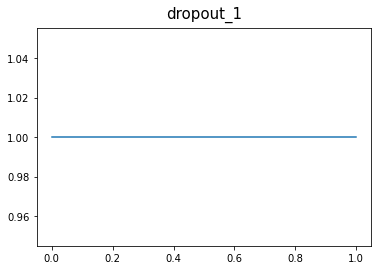

Parameter Name: dropout_2 
Prior Distribution: uniform


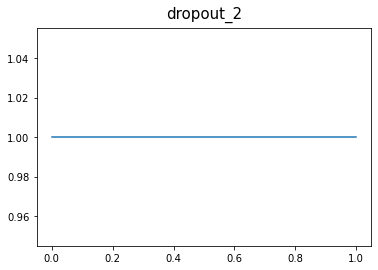

Parameter Name: dropout_3 
Prior Distribution: uniform


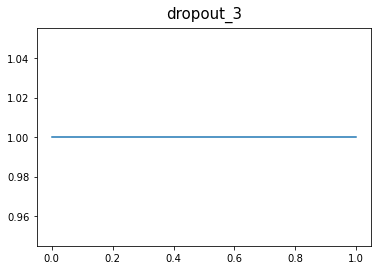

In [8]:
for param in search_space:
    if param.var_type == 'real':
        param.plot_prior()

## Running the optimisation function

In [9]:
best_params = optimise(evaluate_nn, search_space,
             minimize=False, population_size=10,
             n_rounds=5, n_children=10, verbose=True)

Working on evolution round: 1
Best score: 0.841269830862681
Best parameters: {'learning_rate': 0.8, 'n_hidden_layers': 2, 'n_epochs': 120, 'batch_size': 16, 'activation_fn': 'relu', 'n_neurons_layer1': 30, 'n_neurons_layer2': 30, 'n_neurons_layer3': 80, 'dropout_1': 0.42, 'dropout_2': 0.6, 'dropout_3': 0.13}
Working on evolution round: 2
Best score: 0.8462387720743815
Best parameters: {'learning_rate': 0.8, 'n_hidden_layers': 1, 'n_epochs': 20, 'batch_size': 10, 'activation_fn': 'relu', 'n_neurons_layer1': 130, 'n_neurons_layer2': 140, 'n_neurons_layer3': 80, 'dropout_1': 0.65, 'dropout_2': 0.33, 'dropout_3': 0.54}
Working on evolution round: 3
Best score: 0.8650793433189392
Best parameters: {'learning_rate': 0.8, 'n_hidden_layers': 2, 'n_epochs': 100, 'batch_size': 22, 'activation_fn': 'relu', 'n_neurons_layer1': 130, 'n_neurons_layer2': 140, 'n_neurons_layer3': 140, 'dropout_1': 0.62, 'dropout_2': 0.33, 'dropout_3': 0.51}
Working on evolution round: 4
Best score: 0.8655624588330587
B

In [10]:
best_params

{'learning_rate': 0.8,
 'n_hidden_layers': 1,
 'n_epochs': 100,
 'batch_size': 22,
 'activation_fn': 'relu',
 'n_neurons_layer1': 60,
 'n_neurons_layer2': 100,
 'n_neurons_layer3': 140,
 'dropout_1': 0.62,
 'dropout_2': 0.89,
 'dropout_3': 0.51}

**Note**: the best architecture has a single hidden layer. All of the parameters containing the suffix "2" or "3" do not have any implication on the model